<a href="https://colab.research.google.com/github/saidineshpola/Mask2Former/blob/main/mask2former.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍕 Food Recognition Benchmark

# Problem Statement
Detecting & Segmenting various kinds of food from an image. For ex. Someone got into new restaurent and get a food that he has never seen, well our DL model is in rescue, so our DL model will help indentifying which food it is from the class our model is being trained on!    

<img src="https://i.imgur.com/zS2Nbf0.png" width="300" />


# Dataset
We will be using data from Food Recognition Challenge - A benchmark for image-based food recognition challange which is running since 2020.


https://www.aicrowd.com/challenges/food-recognition-benchmark-2022#datasets

We have a total of **39k training images** with **3k validation set** and **4k public-testing set**. All the images are RGB and annotations exist in **MS-COCO format**. 

<img src="https://lh5.googleusercontent.com/iySoTCAHFoEKxjvzELzCJKbZaTG2TzMcjuBxAlBVGupjkpE_XI1xNPnE71UIBthTu9_fZ4A1tz-ArABpI0DD2ZeF87qHPccRogEezd-UbhkQgZcQBYCE1HMeDusaKtj8ClCWjw-p">

# Evaluation

The evaluation metrics is IOU aka. Intersection Over Union ( more about that later ). 

The actualy metric is computed by averaging over all the precision and recall values for IOU which greater than 0.5.

https://www.aicrowd.com/challenges/food-recognition-challenge#evaluation-criteria


# What does this notebook contains?

1. Setting our Workspace 💼

2. Data Exploration 🧐
  - Reading Dataset
  - Data Visualisations 

3. Image Visulisation 🖼️
   - Reading Images

4. Creating our Dataset 🔨
  - Fixing the Dataset
  - Creating our dataset

5. Creating our Model 🏭
   - Creating R-CNN Model
   - Setting up hyperparameters
   
6. Training the Model 🚂
  - Setting up Tensorboard
  - Start Training!

7. Evaluating the model 🧪
  - Evaluating our Model

8. Testing the Model 💯
  - Testing the Model

9. Submitting our predictions 📝



# Setting our Workspace 💼

In this section we will be downloading our dataset, unzipping it & downliading detectron2 library and importing all libraries that we will be using

## Downloading & Unzipping our Dataset

In [1]:
# Login to AIcrowd
!pip install aicrowd-cli > /dev/null
#!aicrowd login

########## or ################
# Get your API key from https://www.aicrowd.com/participants/me
API_KEY = "61a473a8ff6ff34c77e7f9f8544ef7dd"
!aicrowd login --api-key $API_KEY

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
API Key valid
Gitlab oauth token invalid or absent.
It is highly recommended to simply run `aicrowd login` without passing the API Key.
Saved details successfully!


In [2]:
# List dataset for this challenge
!aicrowd dataset list -c food-recognition-benchmark-2022

# Download dataset
!aicrowd dataset download -c food-recognition-benchmark-2022 4 6 7

                          Datasets for challenge #962                           
┌───┬───────────────────────────────┬───────────────────────────────┬──────────┐
│ # │ Title                         │ Description                   │     Size │
├───┼───────────────────────────────┼───────────────────────────────┼──────────┤
│ 0 │ random_prediction.json        │ Random prediction for Quick   │  4.36 MB │
│   │                               │ Submission into Round 2       │          │
│ 1 │ [Round 1]                     │ [Public] Testing Dataset      │     197M │
│   │ public_test_release_2.0.tar.… │ (contains 3000 images and 498 │          │
│   │                               │ categories, without           │          │
│   │                               │ annotations)                  │          │
│ 2 │ [Round 1]                     │ Training Dataset (contains    │   2.14GB │
│   │ public_training_set_release_… │ 39962 images and 498          │          │
│   │                       

In [3]:
!mkdir -p data/ data/train data/val data/test
!echo "Extracting test dataset" && tar -xvf public_test_release_2.1.tar.gz -C data/test  > /dev/null
!echo "Extracting val dataset" && tar -xvf public_validation_set_release_2.1.tar.gz -C data/val  > /dev/null
!echo "Extracting train dataset" && tar -xvf public_training_set_release_2.1.tar.gz -C data/train  > /dev/null
!rm -r *.gz

Extracting test dataset
Extracting val dataset
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
Extracting train dataset


## Mount the Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


So, the `data` directory is something like this:

<img src="https://images.aicrowd.com/uploads/ckeditor/pictures/674/content_carbon__3_.png" width="50%">

In [5]:
!git clone https://github.com/saidineshpola/Mask2Former.git

Cloning into 'Mask2Former'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 323 (delta 68), reused 86 (delta 26), pack-reused 167
Receiving objects: 100% (323/323), 449.46 KiB | 933.00 KiB/s, done.
Resolving deltas: 100% (119/119), done.


## Importing Necessary Libraries

In [ ]:
# Making sure that we are using GPUs
!nvcc --version

In [ ]:
#!pip install -U torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U pycocotools

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
########don't forget to restart the runtime 

In [ ]:

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
########don't forget to restart the runtime 

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm
import subprocess
import time
from pathlib import Path


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import Boxes, BoxMode 
import pycocotools.mask as mask_util


# For reading annotations file
from pycocotools.coco import COCO

# utilities
from pprint import pprint # For beautiful print!
from collections import OrderedDict
import os 

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from google.colab.patches import cv2_imshow

ImportError: ignored

## Fixing the data

In [ ]:
#fix dataset
import numpy as np
import pandas as pd
import cv2
import json
from tqdm import tqdm

# Reading annotations.json
TRAIN_ANNOTATIONS_PATH = "data/train/annotations.json"
TRAIN_IMAGE_DIRECTIORY = "data/train/images/"

VAL_ANNOTATIONS_PATH = "data/val/annotations.json"
VAL_IMAGE_DIRECTIORY = "data/val/images/"

# train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

# Reading the annotation files
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
  val_annotations_data = json.load(f)



# Function for taking a annotation & directiory of images and returning new annoation json with fixed image size info
def fix_data(annotations, directiory, VERBOSE = False):
  for n, i in enumerate(tqdm((annotations['images']))):
   
      img = cv2.imread(directiory+i["file_name"])
 
      if img.shape[0] != i['height']:
          annotations['images'][n]['height'] = img.shape[0]
          if VERBOSE:
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]
          if VERBOSE:
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

  return annotations

train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTIORY)

with open('data/train/new_ann.json', 'w') as f:
    json.dump(train_annotations_data, f)

val_annotations_data = fix_data(val_annotations_data, VAL_IMAGE_DIRECTIORY)

with open('data/val/new_ann.json', 'w') as f:
    json.dump(val_annotations_data, f)

In [9]:
## registering the data
train_annotations_path = 'data/train/new_ann.json'
train_images_path = 'data/train/images'

val_annotations_path = 'data/val/new_ann.json'
val_images_path = 'data/val/images'

register_coco_instances("training_dataset", {},train_annotations_path, train_images_path)
register_coco_instances("validation_dataset", {},val_annotations_path, VAL_IMAGE_DIRECTIORY)

In [ ]:
from detectron2.data.catalog import DatasetCatalog
MetadataCatalog.get("training_dataset")
DatasetCatalog.get("training_dataset")

MetadataCatalog.get("validation_dataset")
data_val_dicts=DatasetCatalog.get("validation_dataset")



In [8]:
!git clone https://github.com/saidineshpola/Mask2Former.git

Cloning into 'Mask2Former'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 320 (delta 66), reused 86 (delta 26), pack-reused 167
Receiving objects: 100% (320/320), 448.75 KiB | 835.00 KiB/s, done.
Resolving deltas: 100% (117/117), done.


## Mask2Former

In [14]:
%cd /content/Mask2Former


/content/Mask2Former


In [ ]:
!pip install -r requirements.txt

In [ ]:
!python train_net.py --config-file configs/coco/instance-segmentation/swin/maskformer2_swin_base_IN21k_384_bs16_50ep.yaml \
  --num-gpus 1  SOLVER.IMS_PER_BATCH 1 SOLVER.BASE_LR 0.00025 

In [ ]:
%cd mask2former/modeling/pixel_decoder/ops
!sh make.sh

In [ ]:
!wget -O base_m2f.pkl "https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_base_IN21k_384_bs16_50ep/model_final_83d103.pkl"

# Creating our Dataset 🔨

In this section we are goind to fix out dataset first ( because there is some issues with dataset ( size mismatch ) & creating our dataset to put into the model

## Fixing the Data

In [ ]:
#example print
np.array(train_annotations_data['annotations'][2]['segmentation']).shape , np.array(train_annotations_data['annotations'][2]['bbox']).shape

((1, 38), (4,))

In [ ]:
# Function for taking a annotation & directiory of images and returning new annoation json with fixed image size info
def fix_data(annotations, directiory, VERBOSE = False):
  for n, i in enumerate(tqdm((annotations['images']))):
   
      img = cv2.imread(directiory+i["file_name"])
 
      if img.shape[0] != i['height']:
          annotations['images'][n]['height'] = img.shape[0]
          if VERBOSE:
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]
          if VERBOSE:
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

  return annotations

#fix annotations for training dataset
train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTIORY)

with open('data/train/new_ann.json', 'w') as f:
    json.dump(train_annotations_data, f)

#similar processing for validation data
val_annotations_data = fix_data(val_annotations_data, VAL_IMAGE_DIRECTIORY)

with open('data/val/new_ann.json', 'w') as f:
    json.dump(val_annotations_data, f)

  0%|          | 0/39962 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#mount the drive for logging and active submission
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

Here comes the actual training part starting with first loading the datasets in coco format and registering them as instances

In [ ]:
train_annotations_path = 'data/train/new_ann.json'
train_images_path = 'data/train/images'

val_annotations_path = 'data/val/new_ann.json'
val_images_path = 'data/val/images'
register_coco_instances("training_dataset", {},train_annotations_path, train_images_path)
register_coco_instances("validation_dataset", {},val_annotations_path, VAL_IMAGE_DIRECTIORY)

# Creating our Detectron2 Model 🏭

We are going to make an Faster R-CNN Model with ResNeXt 101 backbone using Detectron2 libarary, and setting up hyperpamaters to train our model. [Here at model_zoo page](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) you can find available pretrained models to start your traning from. 

## Creating Mask R-CNN Model and Training on Our Dataset

we first load the configuration file for the model architecture, then load the pretrained model from model_zoo. Visit the model_zoo repo page for more details on configuration. 

In [ ]:
# Select your config from model_zoo, we have released pre-trained models for x101 and r50.

# Download available here: https://drive.google.com/drive/folders/10_JiikWP59vm2eGIxRenAXxvYLDjUOz0?usp=sharing (10k iters)
# Pre-trained with score of (0.030 AP, 0.050 AR)
# MODEL_ARCH = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"

# Download available here: https://drive.google.com/drive/folders/1-LLFE8xFGOKkzPXF1DKF45c6O4W-38hu?usp=sharing (110k iters)
# Pre-trained with score of (0.082 AP, 0.128 AR)
MODEL_ARCH = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

cfg = get_cfg()
# Check the model zoo and use any of the models ( from detectron2 github repo)

# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file(MODEL_ARCH))

cfg.DATASETS.TRAIN = ("training_dataset",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2

# Loading pre trained weights
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_ARCH)

## Setting up hyperparameters

Modify the model configuration hyperparameters for our training

In [ ]:
# No. of Batchs
cfg.SOLVER.IMS_PER_BATCH = 4     #for 16 GB GPU, reduce it to 2 for 12 GB GPU if you face CUDA memory error

# Learning Rate: 
cfg.SOLVER.BASE_LR = 0.0025

# No of Interations
cfg.SOLVER.MAX_ITER = 150000

# Options: WarmupMultiStepLR, WarmupCosineLR.
# See detectron2/solver/build.py for definition.
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"

#save every 1000 steps
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

# Images per batch (Batch Size) 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  

# No of Categories(Classes) present
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498



#Output directory
#### NOTE: You can also download pre-trained folder from Google Drive and upload in your drive; links are shared in above cell.
# cfg.OUTPUT_DIR = "/content/drive/MyDrive/logs_detectron2_x101"
cfg.OUTPUT_DIR = "/content/drive/MyDrive/logs_detectron2_r50"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
#set if to true if you want to resume training
RESUME = True
trainer = DefaultTrainer(cfg) 

if RESUME:
  trainer.resume_or_load(resume=True)
else:
  trainer.resume_or_load(resume=False)

[01/31 12:31:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Training the Model 🚂

Finally training our model!

### Start Training!!!

In [ ]:
trainer.train()

## Evaluating the Model on Validation Set!

In [ ]:
# copy the trained model to content directory in colab
!cp '/content/drive/MyDrive/logs_detectron2_r50/model_final.pth' /content/model_final.pth

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = '/content/model_final.pth'

evaluator = COCOEvaluator("validation_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "validation_dataset")
valResults = inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [01/31 11:59:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/31 11:59:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/31 11:59:19 d2.data.datasets.coco]: Loaded 1000 images in COCO format from data/val/new_ann.json
[01/31 11:59:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/31 11:59:20 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[01/31 11:59:20 d2.data.common]: Serialized dataset takes 1.58 MiB
[01/31 11:59:20 d2.evaluation.evaluator]: Start inference on 1000 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[01/31 11:59:22 d2.evaluation.evaluator]: Inference done 11/1000. Dataloading: 0.0022 s/iter. Inference: 0.1114 s/iter. Eval: 0.0237 s/iter. Total: 0.1373 s/iter. ETA=0:02:15
[01/31 11:59:27 d2.evaluation.evaluator]: Inference done 47/1000. Dataloading: 0.0032 s/iter. Inference: 0.1187 s/iter. Eval: 0.0178 s/iter. Total: 0.1399 s/iter. ETA=0:02:13
[01/31 11:59:32 d2.evaluation.evaluator]: Inference done 95/1000. Dataloading: 0.0023 s/iter. Inference: 0.1046 s/iter. Eval: 0.0144 s/iter. Total: 0.1214 s/iter. ETA=0:01:49
[01/31 11:59:37 d2.evaluation.evaluator]: Inference done 141/1000. Dataloading: 0.0021 s/iter. Inference: 0.1018 s/iter. Eval: 0.0136 s/iter. Total: 0.1176 s/iter. ETA=0:01:41
[01/31 11:59:42 d2.evaluation.evaluator]: Inference done 189/1000. Dataloading: 0.0019 s/iter. Inference: 0.1000 s/iter. Eval: 0.0124 s/iter. Total: 0.1144 s/iter. ETA=0:01:32
[01/31 11:59:47 d2.evaluation.evaluator]: Inference done 235/1000. Dataloading: 0.0020 s/iter. Inference: 0.0991 s/iter. Ev

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

cfg.DATASETS.TEST = ("validation_dataset", )
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



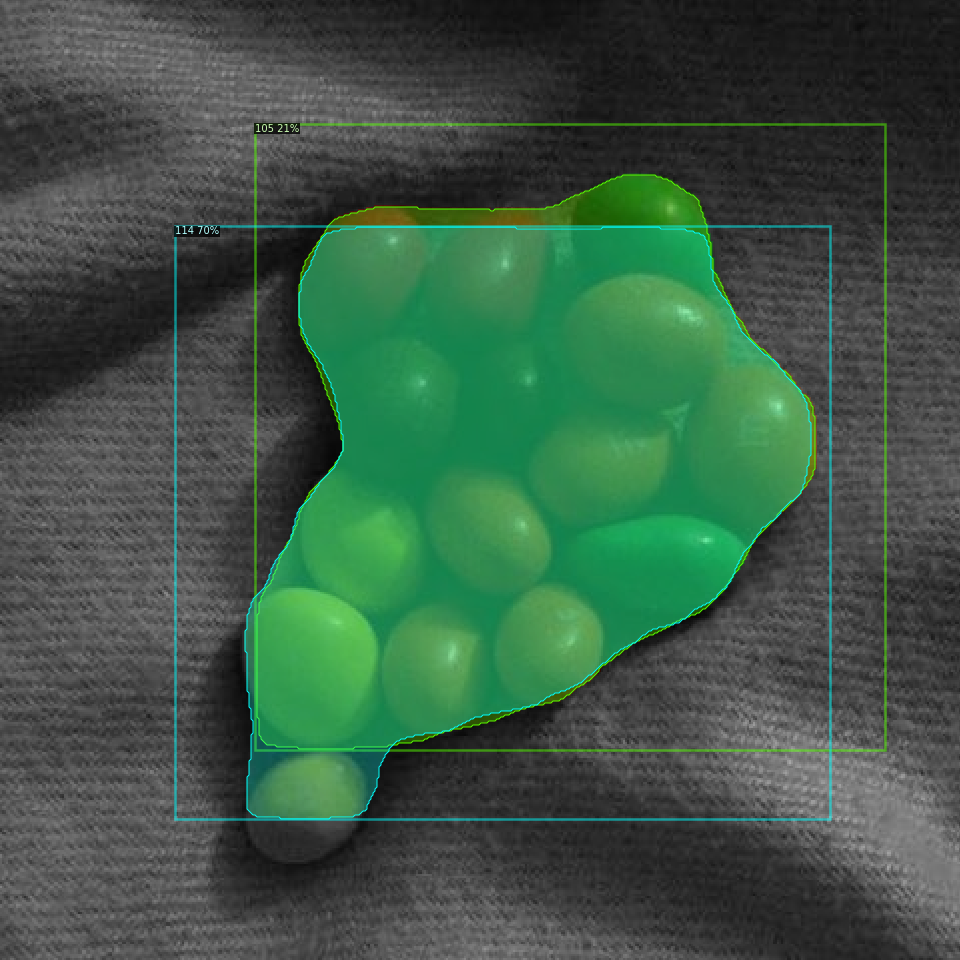

In [ ]:
val_metadata = MetadataCatalog.get("val_dataset")

#sample image 
image_id = '008536'
im = cv2.imread(f"data/val/images/{image_id}.jpg")

outputs = predictor(im)

v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=2,
                   instance_mode=ColorMode.IMAGE_BW
    )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Create Class_to_category mapping to get correct predictions after inference. 

In [ ]:
#generate class category ids from detectron2 internal dictinary mappings
category_ids = sorted(train_coco.getCatIds())
categories = train_coco.loadCats(category_ids)

class_to_category = { int(class_id): int(category_id) for class_id, category_id in enumerate(category_ids) }

with open("class_to_category.json", "w") as fp:
  json.dump(class_to_category, fp)

# Quick Submission 💪

## Inference on the public test set
*   loading the model config and setting up related paths
*   running inference and generating json file for submission



In [ ]:
#setting the paths and threshold
test_images_dir = "/content/data/test/images"
output_filepath = "/content/predictions_detectron2.json"

#path of trained model
model_path = '/content/model_final.pth'
# model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

#threshold
threshold = 0.1

In [ ]:
import os
import json
# import aicrowd_helpers
import importlib
import numpy as np
import cv2
import torch
from detectron2.engine import DefaultPredictor

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import Boxes, BoxMode
from detectron2.config import get_cfg
import pycocotools.mask as mask_util


class_to_category = {}
with open("class_to_category.json") as fp:
    class_to_category = json.load(fp)


def run():
    model_name = "model_zoo"
    model = importlib.import_module(f"detectron2.{model_name}")

    #set the config parameters, including the architecture which was previously used
    cfg = get_cfg()
    cfg.merge_from_file(model.get_config_file(MODEL_ARCH))
    cfg.MODEL.WEIGHTS = model_path

    #set the threshold 
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

    cfg.MODEL.DEVICE = "cuda"
    predictor = DefaultPredictor(cfg)

    results = []
    for img_file in tqdm(os.listdir(test_images_dir)):
        filename = os.path.join(test_images_dir, img_file)
        img = cv2.imread(filename)
        prediction = predictor(img)

        instances = prediction["instances"]
        if len(instances) > 0:
            scores = instances.scores.tolist()
            classes = instances.pred_classes.tolist()
            bboxes = BoxMode.convert(
                instances.pred_boxes.tensor.cpu(),
                BoxMode.XYXY_ABS,
                BoxMode.XYWH_ABS,
            ).tolist()

            masks = []
            if instances.has("pred_masks"):
                for mask in instances.pred_masks.cpu():
                    _mask = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
                    _mask["counts"] = _mask["counts"].decode("utf-8")
                    masks.append(_mask)

            for idx in range(len(instances)):
                category_id = class_to_category[str(classes[idx])] # json converts int keys to str
                output = {
                    "image_id": int(img_file.split(".")[0]),
                    "category_id": category_id,
                    "bbox": bboxes[idx],
                    "score": scores[idx],
                }
                if len(masks) > 0:
                    output["segmentation"] = masks[idx]
                results.append(output)

        with open(output_filepath, "w") as fp:
            json.dump(results, fp)


#run the inference which generates predictions as json file
run()

  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



Now that the prediction file is generated for public test set, To make quick submission:
* Use AIcrowd CLL `aicrowd submit` command to do a quick submission. </br>

**Alternatively:**
* download the `predictions_x101.json` file by running below cell
* visit the [create submission page](https://www.aicrowd.com/challenges/food-recognition-benchmark-2022/submissions/new) 
* Upload the `predictions_x101.json` file 
* Voila!! You just made your first submission!


In [ ]:
#use aicrowd CLI to make quick submission
!aicrowd submission create -c food-recognition-benchmark-2022 -f $output_filepath

predictions_detectron2.json ━━━━━━━━━━━ 100.0% • 8.1/8.1 MB • 2.5 MB/s • 0:00:00
                                               ╭─────────────────────────╮                                               
                                               │ Successfully submitted! │                                               
                                               ╰─────────────────────────╯                                               
                                                     Important links                                                     
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/food-recognition-benchmark-2022/submissions/172533              │
│                  │                                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/food-reco

In [ ]:
!cp '/content/drive/MyDrive/AIcrowd Challenge - Food Recognition/food-recognition-challenge-starter-kit/logs_x101/model_final.pth' model_final.pth

#Active submission 🤩

Step 0 : Fork the baseline to make your own changes to it. Go to settings and make the repo private.


Step 1 : For first time setup, Setting up SSH to login to Gitlab.

  0. Run the next cell to check if you already have SSH keys in your drive, if yes, skip this step. 
  1. Run `ssh-keygen -t ecdsa -b 521` 
  2. Run `cat ~./ssh/id_ecdsa.pub` and copy the output
  3. Go to [Gitlab SSH Keys](https://gitlab.aicrowd.com/profile/keys) and then paste the output inside the key and use whaever title you like. 


Step 2: Clone your forked Repo & Add Models & Push Changes

  1. Run `git clone git@gitlab.aicrowd.com:[Your Username]/food-recognition-2022-detectron2-baseline.git`
  2. Put your model inside the models directioary and then run `git-lfs track "*.pth"`
  3. Run `git add .` then `git commit -m " adding model"`
  3. Run `git push origin master`

Step 3. Create Submission

  1. Go to the repo and then tags and then New Tag. 
  2. In the tag name,you can use `submission_v1`, ( Everytime you make a new submission, just increase the no. like - `submission_v2`,  `submission_v3` )
  3. A new issue will be created with showing the process. Enjoy!




If you do not have SSH Keys, Check this [Page](https://docs.gitlab.com/ee/ssh/index.html#generate-an-ssh-key-pair)

Add your SSH Keys to your GitLab account by following the instructions here

In [ ]:
%%bash
SSH_PRIV_KEY=/content/drive/MyDrive/id_ecdsa
SSH_PUB_KEY=/content/drive/MyDrive/id_ecdsa.pub
if [ -f "$SSH_PRIV_KEY" ]; then
    echo "SSH Key found! ✅\n"
    mkdir -p /root/.ssh
    cp /content/drive/MyDrive/id_ecdsa ~/.ssh/id_ecdsa
    cp /content/drive/MyDrive/id_ecdsa.pub ~/.ssh/id_ecdsa.pub
    echo "SSH key successfully copied to local!"
else
    echo "SSH Key does not exist."
    ssh-keygen -t ecdsa -b521 -f ~/.ssh/id_ecdsa
    cat ~/.ssh/id_ecdsa.pub
    echo "❗️Please open https://gitlab.aicrowd.com/profile/keys and copy-paste the above text in the **key** textbox."
    cp  ~/.ssh/id_ecdsa /content/drive/MyDrive/id_ecdsa
    cp  ~/.ssh/id_ecdsa.pub /content/drive/MyDrive/id_ecdsa.pub
    echo "SSH key successfully created and copied to drive!"
fi

SSH Key found! ✅\n
SSH key successfully copied to local!


In [ ]:
import IPython

html = "<b>Copy paste below SSH key in your GitLab account here (one time):</b><br/>"
html += '<a href="https://gitlab.aicrowd.com/-/profile/keys" target="_blank">https://gitlab.aicrowd.com/-/profile/keys</a><br><br>'

public_key = open("/content/drive/MyDrive/id_ecdsa.pub").read()
html += '<br/><textarea>'+public_key+'</textarea><button onclick="navigator.clipboard.writeText(\''+public_key.strip()+'\');this.innerHTML=\'Copied ✅\'">Click to copy</button>'
IPython.display.HTML(html)

Clone the gitlab starter repo and add submission files

In [ ]:
# Set your AIcrowd username for action submission.
# This username will store repository and used for submitter's username, etc
username = "jerome_patel"
!echo -n {username} > author.txt

In [ ]:
%%bash
username=$(cat author.txt)
echo "Username $username"

git config --global user.name "$username"
git config --global user.email "$username@noreply.gitlab.aicrowd.com"

touch ${HOME}/.ssh/known_hosts
ssh-keyscan -H gitlab.aicrowd.com >> ${HOME}/.ssh/known_hosts 2> /dev/null


apt install -qq -y jq git-lfs &> /dev/null

git lfs install
cd /content/

echo "Checking if repository already exist, otherwise create one"
export SUBMISSION_REPO="git@gitlab.aicrowd.com:$username/food-recognition-2022-detectron2-baseline.git"
echo "cloning the $SUBMISSION_REPO"
git clone $SUBMISSION_REPO food-recognition-2022-detectron2-baseline
ALREADYEXIST=$?

if [ $ALREADYEXIST -ne 0 ]; then
  echo "Project didn't exist, forking from upstream"
  git clone https://github.com/AIcrowd/food-recognition-benchmark-starter-kit.git food-recognition-2022-detectron2-baseline
fi

cd /content/food-recognition-2022-detectron2-baseline
git remote remove origin
git remote add origin "$SUBMISSION_REPO"

Active Submission Repo structure:
* Required Files are `aicrowd.json, apt.txt, requirements.txt, predict.py` 
* Copy detectron2 trained model and `class_to_category.json` to repo
* Modify requirements.txt and predict.py for detectron2
* Modify aicrowd.json for your submission
 

In [ ]:
#@title Modify Requirements.txt (modify and run only if you changed torch/detectron2 or any other library python) { display-mode: "form" }
%%writefile /content/food-recognition-2022-detectron2-baseline/requirements.txt
boto3
cython
numpy
Pillow
pycocotools
pandas
aicrowd-repo2docker
aicrowd-api
opencv-python
pyyaml==5.1

-f https://download.pytorch.org/whl/cu111/torch_stable.html
torch==1.10
torchvision==0.11.1

-f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/index.html
detectron2==0.6

Overwriting /content/food-recognition-2022-detectron2-baseline/requirements.txt


Set `"debug"=false` for actual submission and true for debug, `"gpu"=true` for using the GPU, in our case it's required for detectron2. Modify the `authors` , `SCORE_THRESH_TEST` and `model_config_file`  as per your setup.


In [ ]:
threshold = 0.15
num_classes = cfg.MODEL.ROI_HEADS.NUM_CLASSES
# MODEL_ARCH = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

aicrowd_json = {
  "challenge_id" : "food-recognition-benchmark-2022",
  "authors" : ["jerome_patel"],
  "description" : "Food Recognition Benchmark 2022 Submission",
  "license" : "MIT",
  "gpu": True,
  "debug": False,
  "model_path": "models/model_final.pth",
  "model_type": "model_zoo",
  "model_config_file": MODEL_ARCH,
  "detectron_model_config": {
      "ROI_HEADS": {
        "SCORE_THRESH_TEST": threshold,
        "NUM_CLASSES": num_classes
      }
    }   
}

import json
with open('/content/food-recognition-2022-detectron2-baseline/aicrowd.json', 'w') as fp:
  fp.write(json.dumps(aicrowd_json, indent=4))

In [ ]:
#@title Predict_detectron2 Script, Run only if you modified prediction code
%%writefile /content/food-recognition-2022-detectron2-baseline/predict_detectron2.py

#!/usr/bin/env python
#
# This file uses Detectron2 for instance segmentation.
# It is one of the official baselines for the Food Recognition benchmark 2022 challenge.
#
# NOTE: Detectron2 needs the model and **its** aicrowd.json file to be submitted along with your code.
#
# Making submission using Detectron2:
# 1. Copy the aicrowd_detectron2.json from utils to home directory:
#    #> cp utils/aicrowd_detectron2_example.json aicrowd.json
# 2. Change the model in `predict.py` to Detectron2Predictor.
# 3. Download the pre-trained model from google drive into the folder `./models` using:
#    #> mkdir models
#    #> cd models
#    #> pip install gdown
#    ## To download model trained with "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" architecture and score of 0.03 on leaderboard
#    #> gdown --id 1ylaOzaI6qBfZbICA844uD74dKxLwcd0K --output model_final_mrcnn_x101.pth
#    ## Next line will download "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" achitecture and score of 0.08
#    #> gdown --id 1p5babyX6H80Rt8P8O2ts4g7SJihN2KtV --output model_final_mrcnn_resnet50.pth
# 3. Submit your code using git-lfs
#    #> git lfs install
#    #> git lfs track "*.pth"
#    #> git add .gitattributes
#    #> git add models
#

import os
import json
import glob
from PIL import Image
import importlib
import numpy as np
import cv2
import torch

import pycocotools.mask as mask_util
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.structures import Boxes, BoxMode

from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from evaluator.food_challenge import FoodChallengePredictor


"""
Expected ENVIRONMENT Variables
* AICROWD_TEST_IMAGES_PATH : abs path to  folder containing all the test images
* AICROWD_PREDICTIONS_OUTPUT_PATH : path where you are supposed to write the output predictions.json
"""

class Detectron2Predictor(FoodChallengePredictor):

    """
    PARTICIPANT_TODO:
    You can do any preprocessing required for your codebase here like loading up models into memory, etc.
    """
    def prediction_setup(self):
        # self.PADDING = 50
        # self.SEGMENTATION_LENGTH = 10
        # self.MAX_NUMBER_OF_ANNOTATIONS = 10

        #set the config parameters, including the architecture which was previously used
        self.config = self.get_detectron_config()
        self.model_name = self.config["model_type"]
        self.model = importlib.import_module(f"detectron2.{self.model_name}")
        self.class_to_category = self.get_class_to_category()

        self.cfg = get_cfg()
        self.cfg.merge_from_file(self.model.get_config_file(self.config["model_config_file"]))
        self.cfg.MODEL.WEIGHTS = self.config["model_path"]

        #set the threshold & num classes
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.config["detectron_model_config"]["ROI_HEADS"]["SCORE_THRESH_TEST"]   # set the testing threshold for this model
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

        self.cfg.MODEL.DEVICE = "cuda"
        self.predictor = DefaultPredictor(self.cfg)


    """
    PARTICIPANT_TODO:
    During the evaluation all image file path will be provided one by one.
    NOTE: In case you want to load your model, please do so in `predict_setup` function.
    """
    def prediction(self, image_path):
        print("Generating for", image_path)
        # read the image
        img = cv2.imread(image_path)
        prediction = self.predictor(img)
        
        annotations = []
        instances = prediction["instances"]
        if len(instances) > 0:
            scores = instances.scores.tolist()
            classes = instances.pred_classes.tolist()
            bboxes = BoxMode.convert(
                instances.pred_boxes.tensor.cpu(),
                BoxMode.XYXY_ABS,
                BoxMode.XYWH_ABS,
            ).tolist()

            masks = []
            if instances.has("pred_masks"):
                for mask in instances.pred_masks.cpu():
                    _mask = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
                    _mask["counts"] = _mask["counts"].decode("utf-8")
                    masks.append(_mask)

            for idx in range(len(instances)):
                category_id = self.class_to_category[str(classes[idx])] # json converts int keys to str
                output = {
                    "image_id": int(os.path.basename(image_path).split(".")[0]),
                    "category_id": category_id,
                    "bbox": bboxes[idx],
                    "score": scores[idx],
                }
                if len(masks) > 0:
                    output["segmentation"] = masks[idx]
                annotations.append(output)
        
        # You can return single annotation or array of annotations in your code.
        return annotations

    def get_class_to_category(self):
        class_to_category = {}
        with open("utils/class_to_category.json") as fp:
            class_to_category = json.load(fp)
        return class_to_category

    def get_detectron_config(self):
        with open("aicrowd.json") as fp:
            config = json.load(fp)
        return config


if __name__ == "__main__":
    submission = Detectron2Predictor()
    submission.run()
    print("Successfully generated predictions!")

Overwriting /content/food-recognition-2022-detectron2-baseline/predict_detectron2.py


Copy the Trained model file, `class_to_category.json` and install git-lfs and push the repo with `submission` tag

In [ ]:
%%bash

## Set your unique tag for this submission (no spaces), example:
# export MSG="v1"
# export MSG="v2" ...
# or something more informative...
export MSG="detectron2_submission_v1"


username=$(cat author.txt)
echo "Username $username"

sed -i 's/^submission = .*$/submission = detectron2_predictor/g' predict.py

mkdir -p /content/food-recognition-2022-detectron2-baseline/models
cp /content/class_to_category.json /content/food-recognition-2022-detectron2-baseline/utils/class_to_category.json
cp /content/model_final.pth /content/food-recognition-2022-detectron2-baseline/models/model_final.pth

cd /content/food-recognition-2022-detectron2-baseline
git lfs track "*.pth"
git add .gitattributes
git add --all
git commit -m "$MSG" || true

find . -type f -size +5M -exec git lfs migrate import --include={} &> /dev/null \;

git tag -am "submission_$MSG" "submission_$MSG"
git config lfs.https://gitlab.aicrowd.com/$username/food-recognition-2022-detectron2-baseline.git/info/lfs.locksverify false

git remote remove origin
git remote add origin git@gitlab.aicrowd.com:$username/food-recognition-2022-detectron2-baseline.git

git lfs push origin master
git push origin master
git push origin "submission_$MSG"

echo "Track your submission status here: https://gitlab.aicrowd.com/$username/food-recognition-2022-detectron2-baseline/issues"

Username shivam
Tracking "*.pth"
[master 62ca19a] detectron2_submission_v1
 3 files changed, 23 insertions(+), 7 deletions(-)
 create mode 100644 .gitattributes
 rewrite aicrowd.json (98%)
 create mode 100644 models/model_final.pth
Git LFS: (1 of 1 files) 178.25 MB / 178.25 MB                                  
Git LFS: (0 of 0 files, 1 skipped) 0 B / 0 B, 178.25 MB skipped                

remote: 
remote: 
remote: The private project shivam/food-recognition-2022-detectron2-baseline was successfully created.        
remote: 
remote: To configure the remote, run:        
remote:   git remote add origin git@gitlab.aicrowd.com:shivam/food-recognition-2022-detectron2-baseline.git        
remote: 
remote: To view the project, visit:
remote:   http://gitlab.aicrowd.com/shivam/food-recognition-2022-detectron2-baseline        
remote: 
remote: 
remote: 
To gitlab.aicrowd.com:shivam/food-recognition-2022-detectron2-baseline.git
 * [new branch]      master -> master
remote: 
remote:           #///(            )///#        
remote:          ////      ///      ////        
remote:         /////   //////////   ////        
remote:         /////////////////////////        
remote:      /// /////////////////////// ///        
remote:    ///////////////////////////////////        
remote:   /////////////////////////////////////        
remote:     )////////////////////////////////(     

## Local Evaluation for Active Submission Repo

In [ ]:
%cd /content/food-recognition-2022-detectron2-baseline

/content/food-recognition-2022-detectron2-baseline


In [ ]:
%%bash

export TEST_DATASET_PATH='../data/test/images'
export RESULTS_DATASET_PATH='../data'
./run.sh